# Techniques in ProGAN (https://blog.paperspace.com/understanding-progan/)
## 1. Equalized Learning Rate
- Problem: The learning rate of optimizer Adam and RMSProp depending upon the dynamic range of the parameters (like [-1, 1] or [-10, 10])
- Solution: Scaling the weights with filter size to ensure that every weight is in the same dynamic range.
<img src="files/equalized_lr.jpg" width="400" height="200">

## 2. Pixel Normalization
- Problem: the output will be out of control without batch normalization
- Solution: Add pixel normalization in each channels (dim=1)
<img src="files/pn.jpg" width="400" height="200">

## 3. Loss Function with Gradient Penalty
<img src="files/gp.jpg" width="400" height="200">

## 4. For alpha in Discriminator and Generator
- formula: alpha += current_batch / (total_datasize * 0.5 * no. of epoch in this step) -> it will make alpha reach to 2 sequentially.

## 5. For fade in Descitimator and Generator
<img src="files/fade.jpg" width="800" height="400">

## 6. ProGAN model Architecture
<img src="files/model.jpg" width="800" height="400">

In [18]:
import os
from tqdm import tqdm
import random
import numpy as np
from math import log2

import torch
import torch.nn as nn
import torch.nn.functional as F

# dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.utils import save_image

# visualization
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Download Dataset

In [2]:
! kaggle datasets download -d safiullina/flowers-imitation
! unzip flowers-imitation.zip
! mkdir kaggle && mv flowers_imitation/ kaggle/

Dataset URL: https://www.kaggle.com/datasets/safiullina/flowers-imitation
License(s): CC-BY-SA-4.0
 98% 201M/205M [00:03<00:00, 101MB/s] 
100% 205M/205M [00:03<00:00, 68.8MB/s]
Archive:  flowers-imitation.zip
  inflating: flowers_imitation/0.png  
  inflating: flowers_imitation/1.png  
  inflating: flowers_imitation/10.png  
  inflating: flowers_imitation/100.png  
  inflating: flowers_imitation/1000.png  
  inflating: flowers_imitation/1001.png  
  inflating: flowers_imitation/1002.png  
  inflating: flowers_imitation/1003.png  
  inflating: flowers_imitation/1004.png  
  inflating: flowers_imitation/1005.png  
  inflating: flowers_imitation/1006.png  
  inflating: flowers_imitation/1007.png  
  inflating: flowers_imitation/1008.png  
  inflating: flowers_imitation/1009.png  
  inflating: flowers_imitation/101.png  
  inflating: flowers_imitation/1010.png  
  inflating: flowers_imitation/1011.png  
  inflating: flowers_imitation/1012.png  
  inflating: flowers_imitation/1013.png  
  i

# Configuration

In [3]:
ROOT_DIR = "kaggle"

CHANNEL_RATIOS = [1, 1, 1, 1, 1/2, 1/4, 1/8, 1/16, 1/32] # 9 variables
Z_DIM = 256
INIT_CHANNELS = 256

IMG_SIZES = [4, 8, 16, 32, 64, 128]
BATCH_SIZES = [64, 64, 64, 32, 32, 32]
EPOCHS = [30] * len(IMG_SIZES)

LR = 1e-3

GP_CONSTANT = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define Dataset and DataLoader

torch.Size([16, 3, 128, 128])


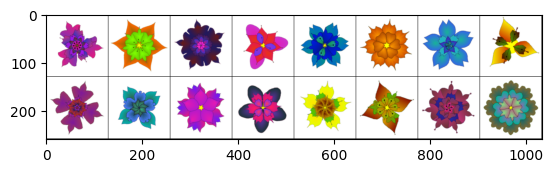

In [4]:
def get_loader(root_dir, steps, batch_size):
    img_size = 4 * 2 ** steps
    tsfm = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(0.5),
        transforms.Normalize([0.5,0.5,0.5], [0.5, 0.5, 0.5])
    ])
    dataset = ImageFolder(root=root_dir, transform=tsfm)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader, dataset

dataloader, dataset = get_loader(ROOT_DIR, 5, 16)
real, _ = next(iter(dataloader))
print(real.size())
plt.imshow(np.transpose(vutils.make_grid(real*0.5+0.5, padding=1, normalize=False), (1,2,0)))

# Define Generator and Discriminator

In [5]:
class WSConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, gain=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels*kernel_size**2)) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x*self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.eps)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, do_pn=True):
        super().__init__()
        self.do_pn = do_pn
        self.conv1 = WSConv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv2 = WSConv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.pn = PixelNorm()
    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.do_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.do_pn else x
        return x

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim, init_channels, img_channels=3):
        super().__init__()
        self.init_block = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, init_channels, 4, 1, 0), # (1,1) -> (4,4)
            nn.LeakyReLU(0.2, inplace=True),
            WSConv2d(init_channels, init_channels, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            PixelNorm()
        )
        self.init_toRGB = WSConv2d(init_channels, 3, kernel_size=1, stride=1, padding=0)
        self.prog_blocks, self.toRGB_layers = nn.ModuleList([]), nn.ModuleList([self.init_toRGB])

        for i in range(0, len(CHANNEL_RATIOS)-1):
            conv_in, conv_out = int(INIT_CHANNELS * CHANNEL_RATIOS[i]),int(INIT_CHANNELS * CHANNEL_RATIOS[i+1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.toRGB_layers.append(WSConv2d(conv_out, 3, kernel_size=1, stride=1, padding=0))

    def fade_in(self, alpha, out, upscaled):
        return torch.tanh(alpha * out + (1 - alpha) * upscaled) # scale data back to range [-1, 1]

    def forward(self, x, alpha, steps):
        x = x.view(x.shape[0], x.shape[1], 1, 1)
        out = self.init_block(x)
        if steps == 0:
            return self.init_toRGB(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        upscaled_rgb = self.toRGB_layers[steps-1](upscaled)
        out_rgb = self.toRGB_layers[steps](out)
        #print(upscaled_rgb.size(), out_rgb.size())
        return self.fade_in(alpha, out_rgb, upscaled_rgb)

class Discriminator(nn.Module):
    def __init__(self, init_channels, img_channels=3):
        super().__init__()
        self.prog_blocks, self.fromRGB_layers = nn.ModuleList([]), nn.ModuleList([])

        for i in range(len(CHANNEL_RATIOS)-1, 0, -1):
            conv_in, conv_out = int(INIT_CHANNELS * CHANNEL_RATIOS[i]), int(INIT_CHANNELS * CHANNEL_RATIOS[i-1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, do_pn=False))
            self.fromRGB_layers.append(WSConv2d(3, conv_in, kernel_size=1, stride=1, padding=0))

        self.init_fromRGB = WSConv2d(3, init_channels, kernel_size=1, stride=1, padding=0)
        self.fromRGB_layers.append(self.init_fromRGB)

        self.final_block = nn.Sequential(
            WSConv2d(init_channels+1, init_channels, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            WSConv2d(init_channels, init_channels, 4, 1, 0),
            nn.LeakyReLU(0.2, inplace=True),
            WSConv2d(init_channels, 1, kernel_size=1, stride=1, padding=0)
        )
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.avg_pool = nn.AvgPool2d(2, 2)

    def fade_in(self, alpha, out, downscaled):
        return alpha * out + (1 - alpha) * downscaled

    def minibatch(self, x):
        minibatch_std = torch.mean(torch.std(x, dim=0)).repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        return torch.concat([x, minibatch_std], dim=1)

    def forward(self, x, alpha, steps):
        cur_step = len(self.prog_blocks) - steps
        #print(cur_step)
        out = self.leaky(self.fromRGB_layers[cur_step](x))
        #print(out.size())
        if steps == 0:
            out = self.minibatch(out)
            return self.final_block(out).view(x.shape[0], -1)

        downscaled = self.leaky(self.fromRGB_layers[cur_step+1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        out = self.fade_in(alpha, out, downscaled)
        for step in range(cur_step+1,  len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)
        out = self.minibatch(out)
        return self.final_block(out).view(x.shape[0], -1)

# Define Gradient Penalty

In [11]:
def calculate_gradien_penalty(netD, real, fake, alpha, steps, device):
    cur_batch_size, C, H, W = real.shape
    beta = torch.rand(cur_batch_size, 1, 1, 1).repeat(1, C, H, W).to(device)
    interpolated_img = beta * real + (1-beta) * fake.detach()
    interpolated_img.requires_grad_(True)
    interpolated_pred = netD(interpolated_img, alpha, steps)

    gradient = torch.autograd.grad(inputs = interpolated_img,\
                                  outputs = interpolated_pred, \
                                  grad_outputs= torch.ones_like(interpolated_pred),\
                                  create_graph= True,\
                                  retain_graph=True,
                                  )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gp  = torch.mean((gradient_norm - 1) ** 2)
    return gp

# Define training function / visualization function on fixed noise

In [13]:
def train_fn(netG, netD, dataloader, dataset, alpha, steps, device, n_epoch):
    train_pbar = tqdm(dataloader)

    for real, _ in train_pbar:
        # update netD
        real = real.to(device)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIM).to(device)
        fake = netG(noise, alpha, steps)

        gp = calculate_gradien_penalty(netD, real, fake, alpha, steps, device)
        real_scores = netD(real, alpha, steps)
        fake_scores = netD(fake.detach(), alpha, steps)
        loss_critic = - torch.mean(real_scores) + torch.mean(fake_scores) \
                      + GP_CONSTANT * gp + (1e-3 * torch.mean(fake_scores**2))

        netD.zero_grad()
        loss_critic.backward()
        optimD.step()

        # update netG
        fake_scores = netD(fake, alpha, steps)
        loss_gen = - torch.mean(fake_scores)
        netG.zero_grad()
        loss_gen.backward()
        optimG.step()
        train_pbar.set_description(f"Epoch:{n_epoch}")
        train_pbar.set_postfix({"GP":f'{gp.detach().item():.2f}', "loss_critic":f'{loss_critic.detach().item():.2f}'})

        alpha += cur_batch_size / (len(dataset) * EPOCHS[steps] * 0.5)
    return alpha

def visual_on_fixed_noise(netG, fixed_noise, alpha, steps, n_epoch):
    netG.eval()
    with torch.no_grad():
        fakes = netG(fixed_noise, alpha, steps)
    fakes = vutils.make_grid(fakes.detach().cpu()*0.5+0.5, padding=1, normalize=False)
    folder = f"step{steps}"
    if not os.path.exists(folder):
        os.makedirs(folder)
    save_image(fakes, os.path.join(folder, f"Epoch_{n_epoch}.jpg"))
    netG.train()
    return

# Major Training Process

In [14]:
netG = Generator(Z_DIM, INIT_CHANNELS).to(DEVICE)
netD = Discriminator(INIT_CHANNELS).to(DEVICE)

optimG = torch.optim.Adam(netG.parameters(), lr=LR, betas=(0.0, 0.99))
optimD = torch.optim.Adam(netD.parameters(), lr=LR, betas=(0.0, 0.99))

fixed_noise = torch.randn(64, Z_DIM).to(DEVICE)

In [16]:
img_sizes = [4, 8, 16, 32, 64, 128]
batch_sizes = [64, 64, 64, 32, 32, 32]
epochs = [30] * len(img_sizes)


same_seed(1314520)
for img_size in IMG_SIZES:
    steps = int(log2(img_size / 4))
    cur_batch_size = BATCH_SIZES[steps]
    print(cur_batch_size)
    alpha = 1e-5
    # each step have 30 epochs
    for n_epoch in range(EPOCHS[steps]):
        dataloader, dataset = get_loader(ROOT_DIR, steps, cur_batch_size)
        alpha = train_fn(netG, netD, dataloader, dataset, alpha, steps, DEVICE, n_epoch)
        print(alpha)
        visual_on_fixed_noise(netG, fixed_noise, alpha, steps, n_epoch)

64


Epoch:0: 100%|██████████| 78/78 [00:18<00:00,  4.29it/s, GP=0.03, loss_critic=-1.85]


0.06667666666666666


Epoch:1: 100%|██████████| 78/78 [00:16<00:00,  4.80it/s, GP=0.01, loss_critic=-1.04]


0.13334333333333284


Epoch:2: 100%|██████████| 78/78 [00:15<00:00,  4.96it/s, GP=0.01, loss_critic=-0.61]


0.20000999999999902


Epoch:3: 100%|██████████| 78/78 [00:15<00:00,  5.00it/s, GP=0.01, loss_critic=-0.57]


0.26667666666666573


Epoch:4: 100%|██████████| 78/78 [00:15<00:00,  4.90it/s, GP=0.02, loss_critic=-0.38]


0.33334333333333405


Epoch:5: 100%|██████████| 78/78 [00:16<00:00,  4.84it/s, GP=0.01, loss_critic=-0.48]


0.40001000000000236


Epoch:6: 100%|██████████| 78/78 [00:15<00:00,  4.95it/s, GP=0.01, loss_critic=-0.18]


0.4666766666666707


Epoch:7: 100%|██████████| 78/78 [00:15<00:00,  4.97it/s, GP=0.01, loss_critic=-0.42]


0.5333433333333389


Epoch:8: 100%|██████████| 78/78 [00:16<00:00,  4.78it/s, GP=0.01, loss_critic=-0.20]


0.6000100000000073


Epoch:9: 100%|██████████| 78/78 [00:15<00:00,  4.92it/s, GP=0.01, loss_critic=-0.27]


0.6666766666666756


Epoch:10: 100%|██████████| 78/78 [00:15<00:00,  4.95it/s, GP=0.01, loss_critic=-0.23]


0.7333433333333439


Epoch:11: 100%|██████████| 78/78 [00:16<00:00,  4.78it/s, GP=0.01, loss_critic=-0.15]


0.8000100000000122


Epoch:12: 100%|██████████| 78/78 [00:15<00:00,  4.95it/s, GP=0.01, loss_critic=-0.26]


0.8666766666666805


Epoch:13: 100%|██████████| 78/78 [00:15<00:00,  4.96it/s, GP=0.01, loss_critic=-0.19]


0.9333433333333488


Epoch:14: 100%|██████████| 78/78 [00:16<00:00,  4.78it/s, GP=0.01, loss_critic=-0.22]


1.0000100000000172


Epoch:15: 100%|██████████| 78/78 [00:15<00:00,  4.96it/s, GP=0.01, loss_critic=-0.23]


1.0666766666666854


Epoch:16: 100%|██████████| 78/78 [00:15<00:00,  4.94it/s, GP=0.01, loss_critic=-0.14]


1.1333433333333536


Epoch:17: 100%|██████████| 78/78 [00:16<00:00,  4.79it/s, GP=0.01, loss_critic=-0.16]


1.2000100000000218


Epoch:18: 100%|██████████| 78/78 [00:15<00:00,  4.96it/s, GP=0.01, loss_critic=-0.11]


1.26667666666669


Epoch:19: 100%|██████████| 78/78 [00:15<00:00,  4.97it/s, GP=0.00, loss_critic=-0.15]


1.3333433333333582


Epoch:20: 100%|██████████| 78/78 [00:16<00:00,  4.87it/s, GP=0.01, loss_critic=-0.06]


1.4000100000000264


Epoch:21: 100%|██████████| 78/78 [00:16<00:00,  4.86it/s, GP=0.01, loss_critic=-0.14]


1.4666766666666946


Epoch:22: 100%|██████████| 78/78 [00:15<00:00,  4.96it/s, GP=0.00, loss_critic=-0.10]


1.5333433333333628


Epoch:23: 100%|██████████| 78/78 [00:15<00:00,  4.96it/s, GP=0.01, loss_critic=-0.03]


1.600010000000031


Epoch:24: 100%|██████████| 78/78 [00:16<00:00,  4.80it/s, GP=0.00, loss_critic=-0.16]


1.6666766666666992


Epoch:25: 100%|██████████| 78/78 [00:15<00:00,  4.95it/s, GP=0.01, loss_critic=-0.05]


1.7333433333333674


Epoch:26: 100%|██████████| 78/78 [00:15<00:00,  4.95it/s, GP=0.00, loss_critic=-0.11]


1.8000100000000356


Epoch:27: 100%|██████████| 78/78 [00:16<00:00,  4.79it/s, GP=0.00, loss_critic=-0.07]


1.8666766666667038


Epoch:28: 100%|██████████| 78/78 [00:15<00:00,  4.92it/s, GP=0.00, loss_critic=-0.20]


1.933343333333372


Epoch:29: 100%|██████████| 78/78 [00:15<00:00,  4.98it/s, GP=0.00, loss_critic=-0.10]


2.0000100000000405
64


Epoch:0: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s, GP=0.00, loss_critic=-0.87]


0.06667666666666666


Epoch:1: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s, GP=0.00, loss_critic=0.43]


0.13334333333333284


Epoch:2: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s, GP=0.00, loss_critic=0.14]


0.20000999999999902


Epoch:3: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s, GP=0.00, loss_critic=-0.48]


0.26667666666666573


Epoch:4: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s, GP=0.01, loss_critic=-0.03]


0.33334333333333405


Epoch:5: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s, GP=0.00, loss_critic=-0.09]


0.40001000000000236


Epoch:6: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s, GP=0.00, loss_critic=-0.01]


0.4666766666666707


Epoch:7: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s, GP=0.01, loss_critic=-0.05]


0.5333433333333389


Epoch:8: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s, GP=0.00, loss_critic=-0.13]


0.6000100000000073


Epoch:9: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s, GP=0.00, loss_critic=-0.39]


0.6666766666666756


Epoch:10: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s, GP=0.01, loss_critic=-0.15]


0.7333433333333439


Epoch:11: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s, GP=0.01, loss_critic=-0.50]


0.8000100000000122


Epoch:12: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s, GP=0.01, loss_critic=-0.23]


0.8666766666666805


Epoch:13: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s, GP=0.00, loss_critic=0.28]


0.9333433333333488


Epoch:14: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s, GP=0.00, loss_critic=-0.12]


1.0000100000000172


Epoch:15: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s, GP=0.01, loss_critic=0.04]


1.0666766666666854


Epoch:16: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s, GP=0.01, loss_critic=-0.30]


1.1333433333333536


Epoch:17: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s, GP=0.00, loss_critic=0.27]


1.2000100000000218


Epoch:18: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s, GP=0.01, loss_critic=-0.10]


1.26667666666669


Epoch:19: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s, GP=0.01, loss_critic=-0.21]


1.3333433333333582


Epoch:20: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s, GP=0.01, loss_critic=-0.05]


1.4000100000000264


Epoch:21: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s, GP=0.02, loss_critic=0.27]


1.4666766666666946


Epoch:22: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s, GP=0.01, loss_critic=0.29]


1.5333433333333628


Epoch:23: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s, GP=0.01, loss_critic=-0.16]


1.600010000000031


Epoch:24: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s, GP=0.00, loss_critic=-0.21]


1.6666766666666992


Epoch:25: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s, GP=0.01, loss_critic=-0.09]


1.7333433333333674


Epoch:26: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s, GP=0.01, loss_critic=0.20]


1.8000100000000356


Epoch:27: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s, GP=0.01, loss_critic=-0.22]


1.8666766666667038


Epoch:28: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s, GP=0.01, loss_critic=-0.03]


1.933343333333372


Epoch:29: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s, GP=0.01, loss_critic=0.08]


2.0000100000000405
64


Epoch:0: 100%|██████████| 78/78 [00:26<00:00,  2.99it/s, GP=0.00, loss_critic=-0.37]


0.06667666666666666


Epoch:1: 100%|██████████| 78/78 [00:25<00:00,  3.06it/s, GP=0.00, loss_critic=-0.29]


0.13334333333333284


Epoch:2: 100%|██████████| 78/78 [00:25<00:00,  3.06it/s, GP=0.00, loss_critic=0.18]


0.20000999999999902


Epoch:3: 100%|██████████| 78/78 [00:25<00:00,  3.05it/s, GP=0.01, loss_critic=-0.43]


0.26667666666666573


Epoch:4: 100%|██████████| 78/78 [00:25<00:00,  3.05it/s, GP=0.00, loss_critic=-0.63]


0.33334333333333405


Epoch:5: 100%|██████████| 78/78 [00:25<00:00,  3.09it/s, GP=0.01, loss_critic=-0.97]


0.40001000000000236


Epoch:6: 100%|██████████| 78/78 [00:25<00:00,  3.06it/s, GP=0.01, loss_critic=-0.87]


0.4666766666666707


Epoch:7: 100%|██████████| 78/78 [00:25<00:00,  3.01it/s, GP=0.01, loss_critic=-0.78]


0.5333433333333389


Epoch:8: 100%|██████████| 78/78 [00:25<00:00,  3.06it/s, GP=0.02, loss_critic=-1.07]


0.6000100000000073


Epoch:9: 100%|██████████| 78/78 [00:25<00:00,  3.06it/s, GP=0.01, loss_critic=-0.66]


0.6666766666666756


Epoch:10: 100%|██████████| 78/78 [00:25<00:00,  3.04it/s, GP=0.02, loss_critic=-0.83]


0.7333433333333439


Epoch:11: 100%|██████████| 78/78 [00:25<00:00,  3.05it/s, GP=0.01, loss_critic=-0.94]


0.8000100000000122


Epoch:12: 100%|██████████| 78/78 [00:25<00:00,  3.05it/s, GP=0.03, loss_critic=-0.79]


0.8666766666666805


Epoch:13: 100%|██████████| 78/78 [00:25<00:00,  3.05it/s, GP=0.01, loss_critic=-0.97]


0.9333433333333488


Epoch:14: 100%|██████████| 78/78 [00:25<00:00,  3.06it/s, GP=0.01, loss_critic=-0.78]


1.0000100000000172


Epoch:15: 100%|██████████| 78/78 [00:25<00:00,  3.03it/s, GP=0.01, loss_critic=-0.73]


1.0666766666666854


Epoch:16: 100%|██████████| 78/78 [00:25<00:00,  3.07it/s, GP=0.01, loss_critic=-1.24]


1.1333433333333536


Epoch:17: 100%|██████████| 78/78 [00:25<00:00,  3.06it/s, GP=0.01, loss_critic=-0.13]


1.2000100000000218


Epoch:18: 100%|██████████| 78/78 [00:25<00:00,  3.05it/s, GP=0.01, loss_critic=-0.25]


1.26667666666669


Epoch:19: 100%|██████████| 78/78 [00:25<00:00,  3.04it/s, GP=0.01, loss_critic=-0.82]


1.3333433333333582


Epoch:20: 100%|██████████| 78/78 [00:25<00:00,  3.04it/s, GP=0.01, loss_critic=-1.04]


1.4000100000000264


Epoch:21: 100%|██████████| 78/78 [00:25<00:00,  3.05it/s, GP=0.01, loss_critic=-0.69]


1.4666766666666946


Epoch:22: 100%|██████████| 78/78 [00:25<00:00,  3.05it/s, GP=0.02, loss_critic=-0.80]


1.5333433333333628


Epoch:23: 100%|██████████| 78/78 [00:25<00:00,  3.02it/s, GP=0.00, loss_critic=-0.79]


1.600010000000031


Epoch:24: 100%|██████████| 78/78 [00:25<00:00,  3.05it/s, GP=0.02, loss_critic=-0.94]


1.6666766666666992


Epoch:25: 100%|██████████| 78/78 [00:25<00:00,  3.04it/s, GP=0.01, loss_critic=-0.95]


1.7333433333333674


Epoch:26: 100%|██████████| 78/78 [00:25<00:00,  3.06it/s, GP=0.01, loss_critic=-0.95]


1.8000100000000356


Epoch:27: 100%|██████████| 78/78 [00:25<00:00,  3.06it/s, GP=0.03, loss_critic=-1.09]


1.8666766666667038


Epoch:28: 100%|██████████| 78/78 [00:25<00:00,  3.06it/s, GP=0.01, loss_critic=-0.59]


1.933343333333372


Epoch:29: 100%|██████████| 78/78 [00:25<00:00,  3.05it/s, GP=0.01, loss_critic=-0.39]


2.0000100000000405
32


Epoch:0: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.01, loss_critic=0.59]


0.06667666666666641


Epoch:1: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.01, loss_critic=-1.97]


0.13334333333333284


Epoch:2: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.02, loss_critic=-2.43]


0.20001000000000116


Epoch:3: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.02, loss_critic=-2.14]


0.26667666666666945


Epoch:4: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.01, loss_critic=-2.04]


0.33334333333333777


Epoch:5: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.02, loss_critic=-0.81]


0.4000100000000061


Epoch:6: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.02, loss_critic=-2.85]


0.4666766666666744


Epoch:7: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.01, loss_critic=-2.76]


0.5333433333333427


Epoch:8: 100%|██████████| 155/155 [01:08<00:00,  2.27it/s, GP=0.03, loss_critic=-3.45]


0.600010000000011


Epoch:9: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.06, loss_critic=-2.38]


0.6666766666666794


Epoch:10: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.10, loss_critic=-4.16]


0.7333433333333477


Epoch:11: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.01, loss_critic=-1.36]


0.800010000000016


Epoch:12: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.01, loss_critic=-2.80]


0.8666766666666843


Epoch:13: 100%|██████████| 155/155 [01:08<00:00,  2.27it/s, GP=0.07, loss_critic=-2.37]


0.9333433333333526


Epoch:14: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.03, loss_critic=-2.82]


1.000010000000021


Epoch:15: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.05, loss_critic=-2.71]


1.0666766666666891


Epoch:16: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.03, loss_critic=-2.46]


1.1333433333333574


Epoch:17: 100%|██████████| 155/155 [01:08<00:00,  2.27it/s, GP=0.03, loss_critic=1.16]


1.2000100000000256


Epoch:18: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.02, loss_critic=-1.89]


1.2666766666666938


Epoch:19: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.04, loss_critic=-1.96]


1.333343333333362


Epoch:20: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.05, loss_critic=-1.24]


1.4000100000000302


Epoch:21: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.04, loss_critic=-0.94]


1.4666766666666984


Epoch:22: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.06, loss_critic=0.10]


1.5333433333333666


Epoch:23: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.04, loss_critic=-3.43]


1.6000100000000348


Epoch:24: 100%|██████████| 155/155 [01:08<00:00,  2.27it/s, GP=0.09, loss_critic=0.42]


1.666676666666703


Epoch:25: 100%|██████████| 155/155 [01:08<00:00,  2.25it/s, GP=0.04, loss_critic=-1.27]


1.7333433333333712


Epoch:26: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.02, loss_critic=-2.15]


1.8000100000000394


Epoch:27: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.02, loss_critic=-1.29]


1.8666766666667076


Epoch:28: 100%|██████████| 155/155 [01:08<00:00,  2.26it/s, GP=0.05, loss_critic=-1.44]


1.9333433333333758


Epoch:29: 100%|██████████| 155/155 [01:08<00:00,  2.27it/s, GP=0.01, loss_critic=-1.44]


2.000010000000044
32


Epoch:0: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.02, loss_critic=-2.86]


0.06667666666666641


Epoch:1: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.03, loss_critic=-6.44]


0.13334333333333284


Epoch:2: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.05, loss_critic=-7.51]


0.20001000000000116


Epoch:3: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.19, loss_critic=-6.92]


0.26667666666666945


Epoch:4: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.06, loss_critic=-7.55]


0.33334333333333777


Epoch:5: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.06, loss_critic=-4.65]


0.4000100000000061


Epoch:6: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.13, loss_critic=-6.88]


0.4666766666666744


Epoch:7: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.09, loss_critic=-1.80]


0.5333433333333427


Epoch:8: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.11, loss_critic=-5.55]


0.600010000000011


Epoch:9: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.16, loss_critic=-6.72]


0.6666766666666794


Epoch:10: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.09, loss_critic=-7.35]


0.7333433333333477


Epoch:11: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.13, loss_critic=-5.51]


0.800010000000016


Epoch:12: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.06, loss_critic=-2.94]


0.8666766666666843


Epoch:13: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.10, loss_critic=-4.68]


0.9333433333333526


Epoch:14: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.11, loss_critic=-8.16]


1.000010000000021


Epoch:15: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.07, loss_critic=0.44]


1.0666766666666891


Epoch:16: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.05, loss_critic=-4.37]


1.1333433333333574


Epoch:17: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.09, loss_critic=-5.33]


1.2000100000000256


Epoch:18: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.02, loss_critic=-5.80]


1.2666766666666938


Epoch:19: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.05, loss_critic=-6.04]


1.333343333333362


Epoch:20: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.03, loss_critic=-0.98]


1.4000100000000302


Epoch:21: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.16, loss_critic=-1.83]


1.4666766666666984


Epoch:22: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.18, loss_critic=-4.74]


1.5333433333333666


Epoch:23: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.07, loss_critic=-6.63]


1.6000100000000348


Epoch:24: 100%|██████████| 155/155 [03:29<00:00,  1.35s/it, GP=0.01, loss_critic=-1.83]


1.666676666666703


Epoch:25: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.02, loss_critic=-3.44]


1.7333433333333712


Epoch:26: 100%|██████████| 155/155 [03:28<00:00,  1.34s/it, GP=0.05, loss_critic=-7.69]


1.8000100000000394


Epoch:27: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.04, loss_critic=-7.64]


1.8666766666667076


Epoch:28: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.07, loss_critic=-3.46]


1.9333433333333758


Epoch:29: 100%|██████████| 155/155 [03:28<00:00,  1.35s/it, GP=0.06, loss_critic=-2.60]


2.000010000000044
32


Epoch:0: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.09, loss_critic=-13.22]


0.06667666666666641


Epoch:1: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.16, loss_critic=-6.57]


0.13334333333333284


Epoch:2: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.29, loss_critic=-6.54]


0.20001000000000116


Epoch:3: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.21, loss_critic=-11.35]


0.26667666666666945


Epoch:4: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.22, loss_critic=-14.19]


0.33334333333333777


Epoch:5: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.13, loss_critic=-18.30]


0.4000100000000061


Epoch:6: 100%|██████████| 155/155 [05:48<00:00,  2.25s/it, GP=0.16, loss_critic=-11.74]


0.4666766666666744


Epoch:7: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.17, loss_critic=-9.88]


0.5333433333333427


Epoch:8: 100%|██████████| 155/155 [05:49<00:00,  2.26s/it, GP=0.19, loss_critic=-7.28]


0.600010000000011


Epoch:9: 100%|██████████| 155/155 [05:49<00:00,  2.26s/it, GP=0.20, loss_critic=-11.80]


0.6666766666666794


Epoch:10: 100%|██████████| 155/155 [05:50<00:00,  2.26s/it, GP=0.17, loss_critic=-2.80]


0.7333433333333477


Epoch:11: 100%|██████████| 155/155 [05:50<00:00,  2.26s/it, GP=0.33, loss_critic=-5.40]


0.800010000000016


Epoch:12: 100%|██████████| 155/155 [05:50<00:00,  2.26s/it, GP=0.16, loss_critic=-18.91]


0.8666766666666843


Epoch:13: 100%|██████████| 155/155 [05:49<00:00,  2.26s/it, GP=0.06, loss_critic=-12.57]


0.9333433333333526


Epoch:14: 100%|██████████| 155/155 [05:49<00:00,  2.26s/it, GP=0.11, loss_critic=-7.84]


1.000010000000021


Epoch:15: 100%|██████████| 155/155 [05:49<00:00,  2.26s/it, GP=0.24, loss_critic=-13.72]


1.0666766666666891


Epoch:16: 100%|██████████| 155/155 [05:49<00:00,  2.26s/it, GP=0.15, loss_critic=-2.33]


1.1333433333333574


Epoch:17: 100%|██████████| 155/155 [05:50<00:00,  2.26s/it, GP=0.19, loss_critic=-10.46]


1.2000100000000256


Epoch:18: 100%|██████████| 155/155 [05:50<00:00,  2.26s/it, GP=0.34, loss_critic=-10.39]


1.2666766666666938


Epoch:19: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.15, loss_critic=-12.29]


1.333343333333362


Epoch:20: 100%|██████████| 155/155 [05:49<00:00,  2.26s/it, GP=0.12, loss_critic=-5.31]


1.4000100000000302


Epoch:21: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.10, loss_critic=-12.77]


1.4666766666666984


Epoch:22: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.12, loss_critic=-4.54]


1.5333433333333666


Epoch:23: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.24, loss_critic=-10.03]


1.6000100000000348


Epoch:24: 100%|██████████| 155/155 [05:49<00:00,  2.26s/it, GP=0.27, loss_critic=-6.68]


1.666676666666703


Epoch:25: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.22, loss_critic=-10.42]


1.7333433333333712


Epoch:26: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.19, loss_critic=-14.02]


1.8000100000000394


Epoch:27: 100%|██████████| 155/155 [05:49<00:00,  2.25s/it, GP=0.19, loss_critic=-11.70]


1.8666766666667076


Epoch:28: 100%|██████████| 155/155 [05:49<00:00,  2.26s/it, GP=0.11, loss_critic=-10.99]


1.9333433333333758


Epoch:29: 100%|██████████| 155/155 [05:48<00:00,  2.25s/it, GP=0.25, loss_critic=-7.49]


2.000010000000044


# Saving and Inference

In [19]:
from google.colab import drive
drive.mount("content")

Mounted at content


In [20]:
! mkdir results && mv step* results
! scp -r results /content/content/MyDrive/MyAIProjects/ProGAN

torch.Size([64, 3, 256, 256])


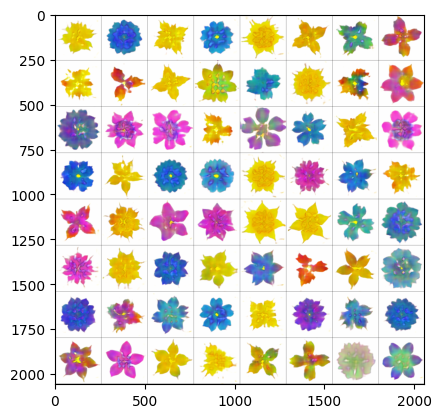

In [28]:
# visualization on fixed noise
netG.eval()
with torch.no_grad():
    fakes = netG(fixed_noise, alpha=0, steps=6)
print(fakes.size())
plt.imshow(np.transpose(vutils.make_grid(fakes.detach().cpu()*0.5+0.5, padding=1, normalize=False), (1,2,0)))

torch.Size([64, 3, 256, 256])


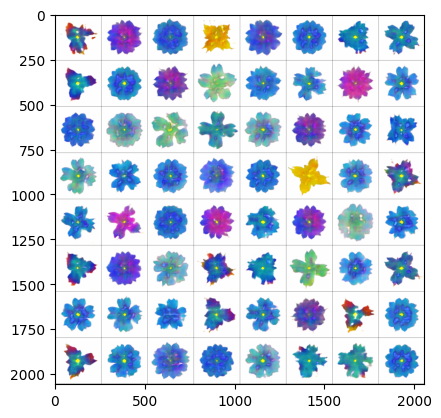

In [40]:
# visualization on fixed noise
netG.eval()
noise = torch.rand(64, Z_DIM).to(DEVICE)
with torch.no_grad():
    fakes = netG(noise, alpha=0, steps=6)
print(fakes.size())
plt.imshow(np.transpose(vutils.make_grid(fakes.detach().cpu()*0.5+0.5, padding=1, normalize=False), (1,2,0)))

In [41]:
torch.save(netG.state_dict(), "/content/content/MyDrive/MyAIProjects/ProGAN/results/netG.pth")
torch.save(netD.state_dict(), "/content/content/MyDrive/MyAIProjects/ProGAN/results/netD.pth")